<a href="https://colab.research.google.com/github/rahiakela/small-language-models-fine-tuning/blob/main/hf-computer-vision-course/01_fine_tuning_vision_transformer_for_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

**Reference**:

[Vision Transformers for Object Detection](https://huggingface.co/learn/computer-vision-course/unit3/vision-transformers/vision-transformer-for-object-detection)

In [ ]:
!pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate

In [1]:
from datasets import load_dataset

from transformers import AutoImageProcessor
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

import albumentations
import numpy as np
import torch
import requests

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Dataset

In [3]:
dataset = load_dataset("anindya64/hardhat")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})

In [6]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

In [4]:
# First, extract out the train and test set
train_dataset = dataset["train"]
test_dataset = dataset["test"]

## Visualize Dataset

In [8]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image

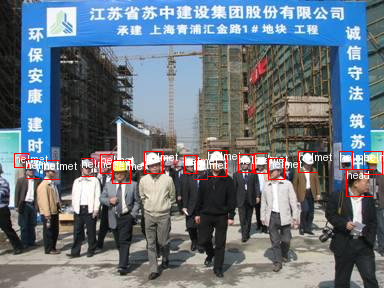

In [9]:
draw_image_from_idx(dataset=train_dataset, idx=10)

In [10]:
def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

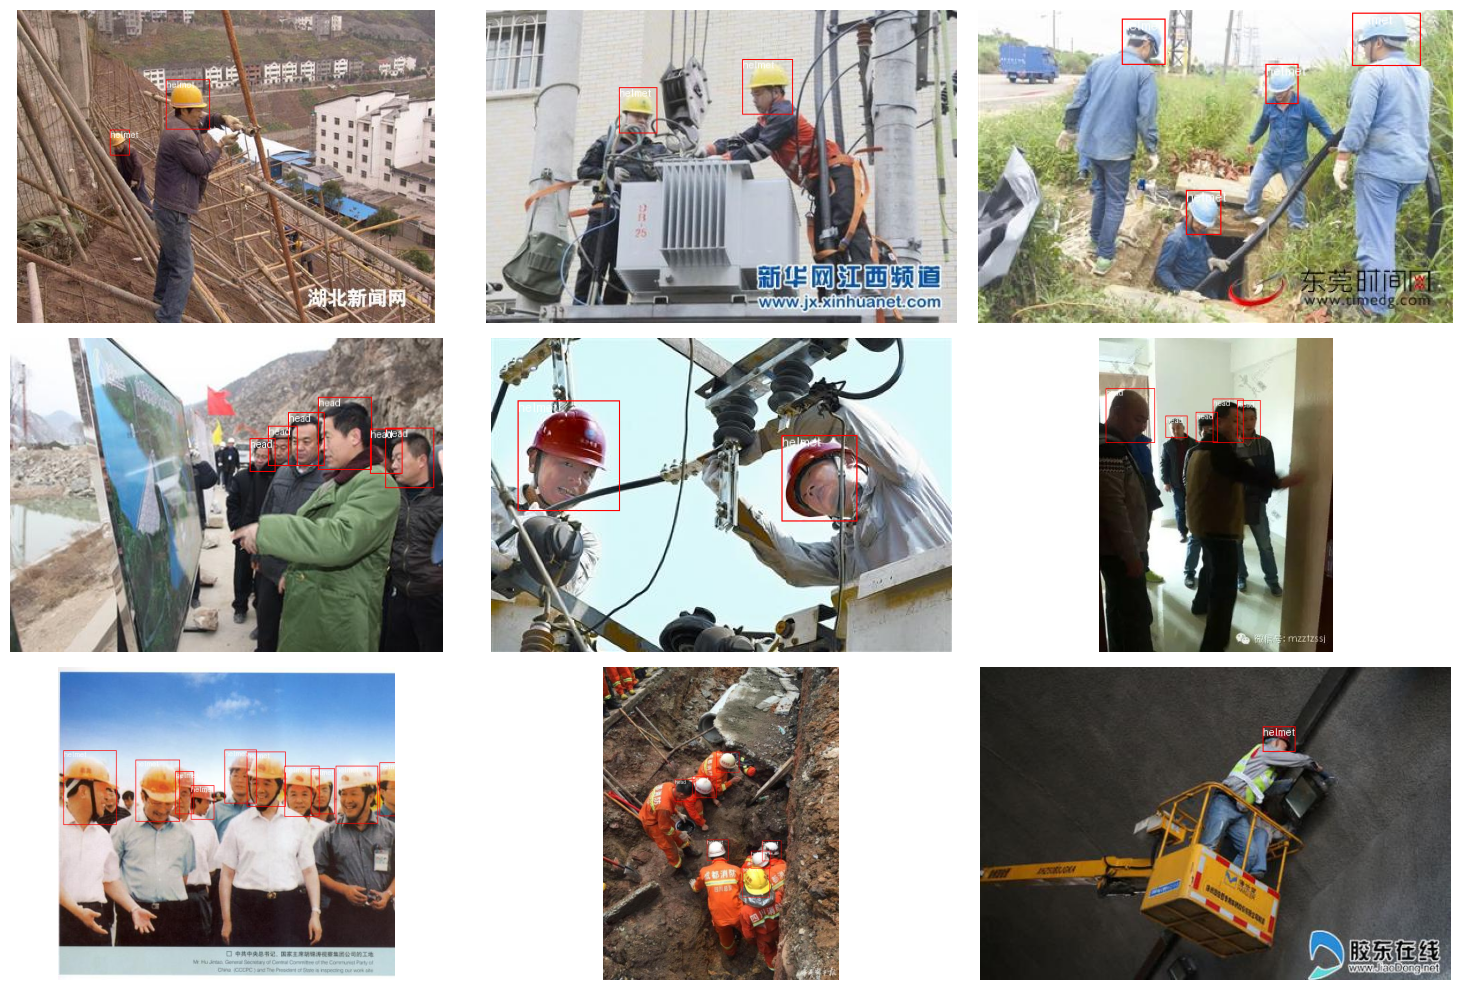

In [11]:
# Now use the function to plot images
plot_images(train_dataset, range(9))

##Preprocessing Dataset

In [ ]:
checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [13]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [14]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [15]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [16]:
# Apply transformations for both train and test dataset
train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

In [17]:
# Now let’s see how a transformed train dataset sample looks like
train_dataset_transformed[0]

{'pixel_values': tensor([[[-0.6623, -0.6623, -0.6623,  ..., -0.8678, -1.0562, -1.1760],
          [-0.6623, -0.6623, -0.6623,  ..., -0.8678, -1.0562, -1.1932],
          [-0.6623, -0.6623, -0.6794,  ..., -0.8849, -1.0733, -1.2103],
          ...,
          [-1.0733, -1.1589, -1.2959,  ..., -1.3644, -1.4329, -1.4843],
          [-1.0733, -1.1760, -1.3130,  ..., -1.3815, -1.4672, -1.5185],
          [-1.0733, -1.1760, -1.3130,  ..., -1.3987, -1.4843, -1.5528]],
 
         [[-0.6176, -0.6176, -0.6176,  ..., -0.4076, -0.6001, -0.7227],
          [-0.6176, -0.6176, -0.6176,  ..., -0.4251, -0.6176, -0.7577],
          [-0.6176, -0.6176, -0.6352,  ..., -0.4426, -0.6527, -0.7927],
          ...,
          [-0.6001, -0.7227, -0.8978,  ..., -1.0553, -1.1253, -1.1604],
          [-0.6001, -0.7227, -0.9153,  ..., -1.0728, -1.1604, -1.1954],
          [-0.6001, -0.7227, -0.9153,  ..., -1.0903, -1.1779, -1.2304]],
 
         [[-0.3055, -0.3055, -0.3055,  ...,  0.3045,  0.1128, -0.0092],
          [-

In [18]:
# A collate_fn is responsible for taking a list of samples from a dataset and converting them into a batch suitable for model’s input format.
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Fine-tune Model

In [ ]:
id2label = {0: "head", 1: "helmet", 2: "person"}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [23]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="detr-resnet-50-hardhat-finetuned",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    max_steps=1000,
    fp16=True,
    save_steps=10,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    processing_class=image_processor,
)

In [24]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 4.12 MiB is free. Process 4071 has 14.73 GiB memory in use. Of the allocated memory 14.47 GiB is allocated by PyTorch, and 144.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [25]:
del model
torch.cuda.synchronize()

## Testing and Inference

In [5]:
# download a sample image
url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/test-helmet-object-detection.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# make the object detection pipeline
obj_detector = pipeline(
    "object-detection", model="anindya64/detr-resnet-50-dc5-hardhat-finetuned"
)
results = obj_detector(train_dataset[0]["image"])

Device set to use cuda:0


In [6]:
print(results)

[{'score': 0.9988328814506531, 'label': 'helmet', 'box': {'xmin': 108, 'ymin': 145, 'xmax': 131, 'ymax': 174}}, {'score': 0.999998927116394, 'label': 'helmet', 'box': {'xmin': 179, 'ymin': 83, 'xmax': 232, 'ymax': 144}}]


In [7]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

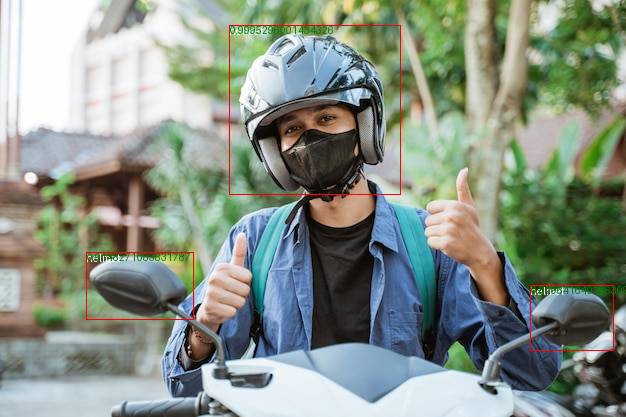

In [8]:
results = obj_detector(image)
plot_results(image, results)

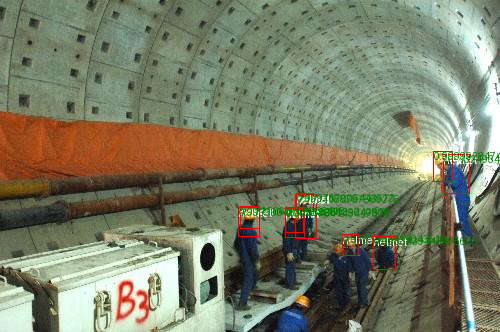

In [9]:
# Now, let’s club everything together into a simple function
def predict(image, pipeline, threshold=0.7):
    results = pipeline(image)
    return plot_results(image, results, threshold)

# Let's test for another test image
img = test_dataset[0]["image"]
predict(img, obj_detector)

Let’s even plot multiple images using our inference function on a small test sample.

In [10]:
from tqdm.auto import tqdm


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(dataset[idx]["image"], obj_detector)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

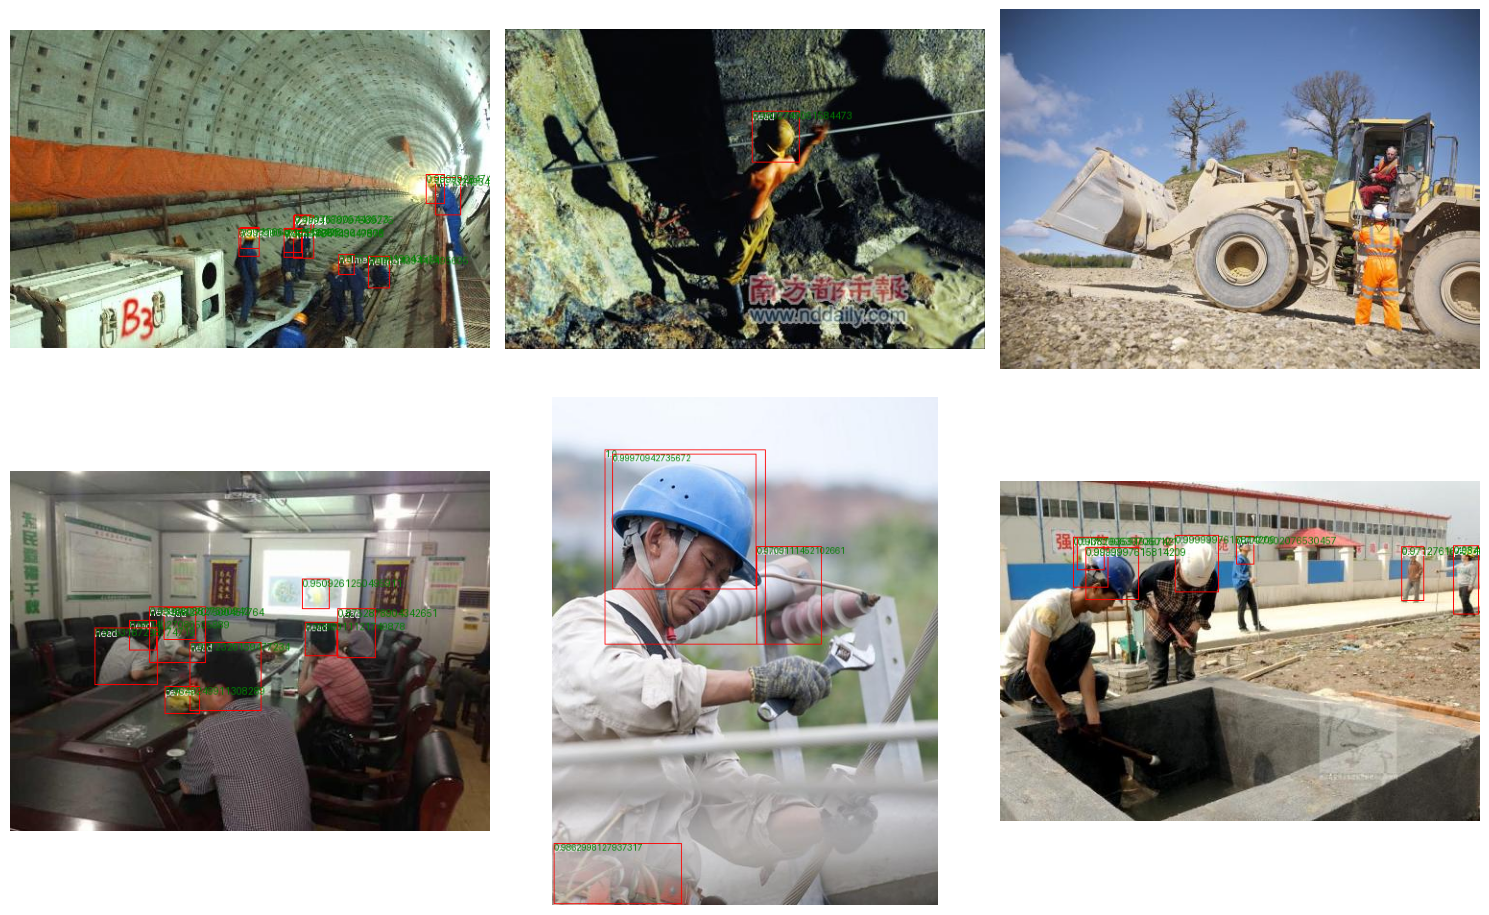

In [11]:
plot_images(test_dataset, range(6))